<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Performance Python

本章将介绍，如何明智地使用数据结构、选择合适的实现方法及范型，以及使用正确的高性能软件包。Python甚至可以与编译型编程语言匹敌，这是因为它本身也是编译后执行的。

### 向量化
利用Python的向量化功能，是前几章已经广泛使用的方法。
### 动态编译
Numba软件包可以让我们使用LLVM技术来动态地编译纯Python代码。
### 静态编译
Cython不仅是一个Python软件包，还是一种组合了Python和C的混合语言。例如，它可以使用静态类型声明，静态编译经过调整的代码。
### 多进程
Python的multiprocessing模块可以简便地实现代码并行执行。

## Loops

### Python

In [1]:
import random

In [2]:
def average_py(n):
    s = 0  
    for i in range(n):
        s += random.random()  
    return s / n  

In [3]:
n = 10000000  

In [4]:
%time average_py(n)  

Wall time: 1.31 s


0.4998858137995871

In [5]:
%timeit average_py(n)  

1.15 s ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%time sum([random.random() for _ in range(n)]) / n  

Wall time: 1.62 s


0.5000110967916729

### NumPy 

NumPy的优势在于其向量化能力。从形式上看，Python级别的循环消失了；循环在更深的一级上，由NumPy提供的优化和预编译例程执行

In [7]:
import numpy as np

In [8]:
def average_np(n):
    s = np.random.random(n)  
    return s.mean()  

In [9]:
%time average_np(n)

Wall time: 113 ms


0.5000011111984018

In [10]:
%timeit average_np(n)

103 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
s = np.random.random(n)
s.nbytes  

80000000

加速很可观，几乎达到10倍（一个数量级）。然而，为此必须付出的代价是明显更高的内存使用率。这是因为NumPy依靠预先分配数据并在编译后的层次内处理来得到高速度。因此，用这种方法无法处理“流化”数据。不同的算法或者问题使用的内存量甚至可能更高。

在一切可能的情况下编写向量化代码是很有诱惑力的，因为它具备简洁的语法，速度通常也有所加快。不过，这些好处也是有代价的，通常带来更大的内存占用。

### Numba

Numba软件包通过使用LLVM可以动态地编译纯Python代码。在简单的情况下（如以下的代码），它的应用非常直观

In [12]:
import numba

In [13]:
average_nb = numba.jit(average_py)  

In [14]:
# 编译发生在运行时，会带来一些开销。
%time average_nb(n)  

Wall time: 233 ms


0.49994304222313835

In [15]:
# 从第二次执行（使用相同的输入数据类型）起，执行更快了。
%time average_nb(n)  

Wall time: 62 ms


0.4999846193978235

In [16]:
%timeit average_nb(n)  

57.5 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


纯Python和Numba的组合战胜了NumPy版本，并且保留了基于循环的原始实现的内存效率。还有一点很明显，在这种简单情况下应用Numba几乎没有任何编程开销

对比Python代码和编译版本的性能，Numba的应用有时就像魔法，特别是它还很易于使用。不过，许多情况下Numba并不适用，性能增进几乎难以察觉，甚至无法实现。

### Cython

Cython可以静态编译Python代码。但是，它的应用不像Numba那么简单，通常需要更改代码才能看到明显的加速

In [17]:
import sys
sys.version

'3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]'

Windows10使用cython参考网站：
[個人用メモ： AnacondaでCythonを使うための設定 - Qiita](https://qiita.com/kajiki0011/items/c962804adceb6ad49566)

In [18]:
# 在notebook上可以编译cython
%load_ext Cython

In [19]:
%%cython -a
# 使用cython编译
import random  
def average_cy1(int n):  
    cdef int i  # 使用cdef进行静态型宣言
    cdef float s = 0  
    for i in range(n):
        s += random.random()
    return s / n

In [20]:
%time average_cy1(n)

Wall time: 480 ms


0.5001121759414673

In [22]:
%timeit average_cy1(n)

487 ms ± 4.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%cython
from libc.stdlib cimport rand # 从C中导入一个随机数生成器 
cdef extern from 'limits.h':  # 导入一个恒定值，对随机数按比例进行调整
    int INT_MAX  
cdef int i
cdef float rn
for i in range(5):
    rn = rand() / INT_MAX  
    print(rn)

5.344860255718231e-06
1.3670884072780609e-05
1.2555159628391266e-05
1.1391937732696533e-05
2.6565976440906525e-06


In [25]:
%%cython -a
from libc.stdlib cimport rand  
cdef extern from 'limits.h':  
    int INT_MAX  
def average_cy2(int n):
    cdef int i
    cdef float s = 0
    for i in range(n):
        s += rand() / INT_MAX  
    return s / n

In [26]:
%time average_cy2(n)

Wall time: 188 ms


7.628993898833869e-06

In [27]:
%timeit average_cy2(n)

186 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Cython使开发人员可以尽可能地调整代码以提高性能，也可以明智地少做调整——例如，从纯Python版本入手，向代码中加入越来越多的C语言元素。在编译步骤中也可以设置参数，以进一步优化编译后的版本。

## Prime Numbers
本节将上一节的性能增强技术应用到一些著名的数学问题和算法上。这些算法经常用作性能基准。

### Pure Python

In [29]:
def is_prime(I):
    if I % 2 == 0: return False  
    for i in range(3, int(I ** 0.5) + 1, 2):  
        if I % i == 0: return False  
    return True  

In [30]:
n = int(1e8 + 3)  
n

100000003

In [31]:
%time is_prime(n)

Wall time: 0 ns


False

In [32]:
p1 = int(1e8 + 7)  
p1

100000007

In [33]:
%time is_prime(p1)

Wall time: 0 ns


True

In [34]:
p2 = 100109100129162907  

In [35]:
p2.bit_length()  

57

In [36]:
%time is_prime(p2)

Wall time: 16.2 s


True

### Numba
函数is_prime()中的算法循环结构由Numba动态编译。开销仍然很少，而加速效果很可观

In [37]:
is_prime_nb = numba.jit(is_prime)

In [38]:
%time is_prime_nb(n)  

Wall time: 110 ms


False

In [39]:
%time is_prime_nb(n)  

Wall time: 0 ns


False

In [40]:
%time is_prime_nb(p1)

Wall time: 0 ns


True

In [41]:
%time is_prime_nb(p2)  

Wall time: 1.3 s


True

### Cython

In [42]:
%%cython
def is_prime_cy1(I):
    if I % 2 == 0: return False
    for i in range(3, int(I ** 0.5) + 1, 2):
        if I % i == 0: return False
    return True

In [43]:
%timeit is_prime(p1)

269 µs ± 467 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [44]:
%timeit is_prime_cy1(p1)

155 µs ± 167 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [45]:
%%cython
def is_prime_cy2(long long I):  
    cdef long i  
    if I % 2 == 0: return False
    for i in range(3, int(I ** 0.5) + 1, 2):
        if I % i == 0: return False
    return True

In [46]:
%timeit is_prime_cy2(p1)

39.2 µs ± 100 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [47]:
%time is_prime_nb(p2)

Wall time: 1.28 s


True

In [48]:
%time is_prime_cy2(p2)

Wall time: 1.24 s


True

### Multiprocessing

multiprocessing模块有助于进一步加速代码执行。你可以用它产生多个并行运行的 Python 进程。对于简单问题，该模块的应用很直观。首先，将mp.Pool对象设置为多进程。其次，将要执行的函数映射到所要检查的质数上

In [46]:
import multiprocessing as mp

In [47]:
pool = mp.Pool(processes=4)  

In [48]:
%time pool.map(is_prime, 10 * [p1])  

In [ ]:
%time pool.map(is_prime_nb, 10 * [p2])  

In [ ]:
%time pool.map(is_prime_cy2, 10 * [p2])  

每当需要解决多个相同类型问题时，就应该考虑并行处理。如果拥有具备多个核心及充足工作内存的强大硬件，效果可能非常巨大。multiprocessing是标准库中的一个易用模块。

## Fibonacci Numbers

### Recursive Algorithm

In [21]:
from numba import njit

In [23]:
def fib_rec_py1(n):
    if n < 2:
        return n
    else:
        return fib_rec_py1(n - 1) + fib_rec_py1(n - 2)

In [28]:
%time fib_rec_py1(35)

Wall time: 3.41 s


9227465

In [49]:
@njit
def fib_rec_nb(n):
    if n < 2:
        return n
    else:
        return fib_rec_nb(n - 1) + fib_rec_nb(n - 2)

In [50]:
%time fib_rec_nb(35)

Wall time: 146 ms


9227465

In [51]:
%time fib_rec_nb(35)

Wall time: 79 ms


9227465

In [52]:
%%cython
def fib_rec_cy(int n):
    if n < 2:
        return n
    else:
        return fib_rec_cy(n - 1) + fib_rec_cy(n - 2)

In [53]:
%time fib_rec_cy(35)

Wall time: 716 ms


9227465

递归算法的主要问题是中间结果不会缓存，而是重新计算。为了避免出现这种特有的问题，可以使用一个装饰器（decorator）来负责缓存中间结果。它可以将执行速度提高好几个数量级

In [55]:
from functools import lru_cache as cache

In [56]:
# 缓存中间结果
@cache(maxsize=None)  
def fib_rec_py2(n):
    if n < 2:
        return n
    else:
        return fib_rec_py2(n - 1) + fib_rec_py2(n - 2)

In [57]:
%time fib_rec_py2(35)  

Wall time: 0 ns


9227465

In [58]:
%time fib_rec_py2(80)  

Wall time: 0 ns


23416728348467685

### Iterative Algorithm 

In [59]:
def fib_it_py(n):
    x, y = 0, 1
    for i in range(1, n + 1):
        x, y = y, x + y
    return x

In [60]:
%time fib_it_py(80)

Wall time: 0 ns


23416728348467685

In [61]:
fib_it_nb = numba.jit(fib_it_py)

In [62]:
%time fib_it_nb(80)

Wall time: 66 ms


23416728348467685

In [63]:
%time fib_it_nb(80)

Wall time: 0 ns


23416728348467685

In [66]:
%%cython
def fib_it_cy1(int n):
    cdef long long i
    cdef long long x = 0, y = 1
    for i in range(1, n + 1):
        x, y = y, x + y
    return x

In [67]:
%time fib_it_cy1(80)

Wall time: 0 ns


23416728348467685

In [77]:
%%time
fn = fib_rec_py2(150)  
print(fn)  

9969216677189303386214405760200
Wall time: 986 µs


In [69]:
fn.bit_length()  

103

In [72]:
%%time 
fn = fib_it_nb(150)  
print(fn)  

6792540214324356296
Wall time: 0 ns


In [71]:
fn.bit_length()  

63

In [73]:
%%time
fn = fib_it_cy1(150)  
print(fn)  

6792540214324356296
Wall time: 0 ns


In [79]:
fn.bit_length()  

103

In [91]:
%%cython
cdef extern from *:
    ctypedef int int128 '__int128_t'  
def fib_it_cy2(int n):
    cdef int128 i  
    cdef int128 x = 0, y = 1  
    for i in range(1, n + 1):
        x, y = y, x + y
    return x

In [92]:
%%time
fn = fib_it_cy2(150)  
print(fn)  

6792540214324356296
Wall time: 0 ns


In [93]:
fn.bit_length()  

63

由于64位整数对象的限制，遇到了溢出问题

## The Number Pi

基于蒙特卡洛模拟的π值求取算法

The code example is taken from [StackExchange](https://codereview.stackexchange.com/questions/69370/monte-carlo-pi-calculation).

In [94]:
import random
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [95]:
rn = [(random.random() * 2 - 1, random.random() * 2 - 1)
      for _ in range(500)]

In [96]:
rn = np.array(rn)
rn[:5]

array([[ 0.95936061, -0.92966821],
       [-0.11405703,  0.42470868],
       [ 0.81213307,  0.29452811],
       [-0.81993325, -0.69682838],
       [ 0.90759144, -0.77368804]])

(-1.1, 1.1)

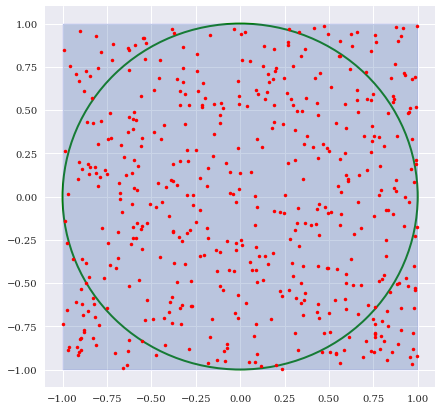

In [97]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((0, 0), radius=1, edgecolor='g', lw=2.0,
                  facecolor='None')  
box = plt.Rectangle((-1, -1), 2, 2, edgecolor='b', alpha=0.3)  
ax.add_patch(circ)  
ax.add_patch(box)  
plt.plot(rn[:, 0], rn[:, 1], 'r.')  
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
# plt.savefig('../../images/ch10/perf_01.png');

In [98]:
n = int(1e7)

In [99]:
%time rn = np.random.random((n, 2)) * 2 - 1

Wall time: 336 ms


In [100]:
rn.nbytes

160000000

In [101]:
%time distance = np.sqrt((rn ** 2).sum(axis=1))  
distance[:8].round(3)

Wall time: 235 ms


array([0.525, 1.198, 0.861, 0.963, 0.603, 0.667, 0.73 , 0.636])

In [102]:
%time frac = (distance <= 1.0).sum() / len(distance)  

Wall time: 21 ms


In [103]:
pi_mcs = frac * 4  
pi_mcs  

3.1412344

In [104]:
def mcs_pi_py(n):
    circle = 0
    for _ in range(n):
        x, y = random.random(), random.random()
        if (x ** 2 + y ** 2) ** 0.5 <= 1:
            circle += 1
    return (4 * circle) / n

In [105]:
%time mcs_pi_py(n)

Wall time: 6.97 s


3.1408784

In [106]:
mcs_pi_nb = numba.jit(mcs_pi_py)

In [107]:
%time mcs_pi_nb(n)

Wall time: 333 ms


3.1419172

In [108]:
%time mcs_pi_nb(n)

Wall time: 132 ms


3.1414324

In [109]:
%%cython -a
import random
def mcs_pi_cy1(int n):
    cdef int i, circle = 0
    cdef float x, y
    for i in range(n):
        x, y = random.random(), random.random()
        if (x ** 2 + y ** 2) ** 0.5 <= 1:
            circle += 1
    return (4 * circle) / n

In [110]:
%time mcs_pi_cy1(n)

Wall time: 1.43 s


3.140782

In [111]:
%%cython -a
from libc.stdlib cimport rand
cdef extern from 'limits.h':
    int INT_MAX
def mcs_pi_cy2(int n):
    cdef int i, circle = 0
    cdef float x, y
    for i in range(n):
        x, y = rand() / INT_MAX, rand() / INT_MAX
        if (x ** 2 + y ** 2) ** 0.5 <= 1:
            circle += 1
    return (4 * circle) / n

In [113]:
%time mcs_pi_cy2(n)

Wall time: 1.14 s


4.0

## Binomial Trees

二项式期权定价模型是一种流行的期权定价数值方法，是由Cox、Ross和Rubinstein率先提出的。这种方法以一棵（重组）树来表示某种资产可能的未来发展。这种模型的设置和Black-Scholes-Merton的设置一样，有风险资产（指数或者股票）以及无风险资产（债券）。

### Python

In [114]:
import math

In [116]:
# 风险资产初始价值
S0 = 36.  
# 二叉树模拟的时间范围
T = 1.0  
# 恒定的短期利率
r = 0.06  
# 恒定的波动率因数
sigma = 0.2  

In [117]:
def simulate_tree(M):
    dt = T / M  # 时间间隔
    u = math.exp(sigma * math.sqrt(dt))  # 向上和向下运动因数
    d = 1 / u  
    S = np.zeros((M + 1, M + 1))
    S[0, 0] = S0
    z = 1
    for t in range(1, M + 1):
        for i in range(z):
            S[i, t] = S[i, t-1] * u
            S[i+1, t] = S[i, t-1] * d
        z += 1
    return S

In [118]:
np.set_printoptions(formatter={'float':
                               lambda x: '%6.2f' % x})  

In [119]:
# 与典型的树图不同，向上运动在ndarray对象中表现为侧向运动，这显著减小了ndarray的大小
simulate_tree(4)  

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]])

In [120]:
%time simulate_tree(500)  

Wall time: 114 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [  0.00,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [  0.00,   0.00,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]])

### NumPy

上述二叉树可用NumPy全向量化代码创建

In [121]:
M = 4

In [122]:
up = np.arange(M + 1)
up = np.resize(up, (M + 1, M + 1))  
up
# 包含总向上运动的ndarray对象

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [125]:
down = up.T * 2  
down
# 包含总向下运动的ndarray对象

array([[0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2],
       [4, 4, 4, 4, 4],
       [6, 6, 6, 6, 6],
       [8, 8, 8, 8, 8]])

In [126]:
up - down 
# 包含净向上（正）和向下运动的ndarray对象 
# 按照规律，由左往右是乘上e^u,由上往下是乘上e^2d = e^-2u。
# 所以一开始直接做出次数矩阵进行计算即可

array([[ 0,  1,  2,  3,  4],
       [-2, -1,  0,  1,  2],
       [-4, -3, -2, -1,  0],
       [-6, -5, -4, -3, -2],
       [-8, -7, -6, -5, -4]])

In [127]:
dt = T / M

In [128]:
S0 * np.exp(sigma * math.sqrt(dt) * (up - down)) 
# 4个时间间隔的树（值的右上方三角形） 

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [ 29.47,  32.57,  36.00,  39.79,  43.97],
       [ 24.13,  26.67,  29.47,  32.57,  36.00],
       [ 19.76,  21.84,  24.13,  26.67,  29.47],
       [ 16.18,  17.88,  19.76,  21.84,  24.13]])

In [129]:
def simulate_tree_np(M):
    dt = T / M
    up = np.arange(M + 1)
    up = np.resize(up, (M + 1, M + 1))
    down = up.transpose() * 2
    S = S0 * np.exp(sigma * math.sqrt(dt) * (up - down))
    return S

In [130]:
simulate_tree_np(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [ 29.47,  32.57,  36.00,  39.79,  43.97],
       [ 24.13,  26.67,  29.47,  32.57,  36.00],
       [ 19.76,  21.84,  24.13,  26.67,  29.47],
       [ 16.18,  17.88,  19.76,  21.84,  24.13]])

In [132]:
%time simulate_tree_np(500)

Wall time: 9 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [ 35.36,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [ 34.73,  35.05,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.41,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.40,   0.41,   0.41]])

In [133]:
# 个人优化：如果想要维持树图的形式，ndarray的左下角部分是不需要的
# 取ndarray的上三角用triu()，下三角用tril()
def simulate_tree_np2(M):
    dt = T / M
    up = np.arange(M + 1)
    up = np.resize(up, (M + 1, M + 1))
    down = up.transpose() * 2
    S = S0 * np.exp(sigma * math.sqrt(dt) * (up - down))
    return np.triu(S)

In [135]:
%time simulate_tree_np2(4)

Wall time: 0 ns


array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]])

In [136]:
%time simulate_tree_np2(1000)

Wall time: 32 ms


array([[ 36.00,  36.23,  36.46, ..., 19839.40, 19965.27, 20091.94],
       [  0.00,  35.77,  36.00, ..., 19590.03, 19714.32, 19839.40],
       [  0.00,   0.00,  35.55, ..., 19343.79, 19466.52, 19590.03],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.07,   0.07,   0.07],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.06,   0.07],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.06]])

### Numba

这种金融算法应该很适合于通过 Numba 动态编译来优化。

In [137]:
simulate_tree_nb = numba.jit(simulate_tree)

In [138]:
simulate_tree_nb(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]])

In [139]:
%time simulate_tree_nb(500)

Wall time: 1e+03 µs


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [  0.00,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [  0.00,   0.00,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]])

In [140]:
%timeit simulate_tree_nb(500)

916 µs ± 34.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Cython

In [141]:
%%cython -a
import numpy as np
cimport cython
from libc.math cimport exp, sqrt
cdef float S0 = 36.
cdef float T = 1.0
cdef float r = 0.06
cdef float sigma = 0.2
def simulate_tree_cy(int M):
    cdef int z, t, i
    cdef float dt, u, d
    cdef float[:, :] S = np.zeros((M + 1, M + 1),
                                  dtype=np.float32)  
    dt = T / M
    u = exp(sigma * sqrt(dt))
    d = 1 / u
    S[0, 0] = S0
    z = 1
    for t in range(1, M + 1):
        for i in range(z):
            S[i, t] = S[i, t-1] * u
            S[i+1, t] = S[i, t-1] * d
        z += 1
    return np.array(S)

In [142]:
simulate_tree_cy(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]], dtype=float32)

In [143]:
%time simulate_tree_cy(500)

Wall time: 2 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.77, 3123.59, 3151.65],
       [  0.00,  35.68,  36.00, ..., 3040.89, 3068.21, 3095.77],
       [  0.00,   0.00,  35.36, ..., 2986.97, 3013.81, 3040.89],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]],
      dtype=float32)

In [144]:
%timeit S = simulate_tree_cy(500)

914 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Monte Carlo Simulation

蒙特卡洛模拟是计算金融学中不可或缺的数值工具，在现代计算机出现之前就已经投入使用。银行和其他金融机构将其用于定价和风险管理，这种方法可能是金融学中最为灵活和强大的数值方法之一。不过，它也往往是计算要求最高的。因此，Python长期被排除在实现基于蒙特卡洛模拟算法的合适编程语言之外——至少在现实应用场景里是这样。

### Python

In [145]:
# 离散化的时间间隔数量
M = 100  
# 模拟的路径数量
I = 50000  

In [147]:
def mcs_simulation_py(p):
    M, I = p
    dt = T / M
    S = np.zeros((M + 1, I))
    S[0] = S0
    rn = np.random.standard_normal(S.shape)  #用单一向量化步骤提取的随机数
    for t in range(1, M + 1):  # 实现基于欧拉格式模拟的嵌套循环
        for i in range(I):  
            S[t, i] = S[t-1, i] * math.exp((r - sigma ** 2 / 2) * dt + sigma * math.sqrt(dt) * rn[t, i])  
    return S      

In [148]:
%time S = mcs_simulation_py((M, I))

Wall time: 6.98 s


In [150]:
S

array([[ 36.00,  36.00,  36.00, ...,  36.00,  36.00,  36.00],
       [ 36.46,  34.73,  36.04, ...,  34.86,  35.87,  35.54],
       [ 36.53,  35.00,  35.80, ...,  34.84,  36.27,  35.10],
       ...,
       [ 34.14,  36.07,  38.29, ...,  34.82,  47.77,  34.47],
       [ 34.61,  37.39,  38.60, ...,  34.99,  45.72,  34.64],
       [ 34.93,  36.49,  39.20, ...,  35.57,  46.72,  35.20]])

In [149]:
S[-1].mean()
# 根据模拟算出的期末价值均值

38.25534392751107

In [151]:
S0 * math.exp(r * T) 
# 理论预期期末价值

38.22611567563295

In [152]:
K = 40.  
# 欧洲看跌期权行权价

In [154]:
# 蒙特卡洛期权估值函数
C0 = math.exp(-r * T) * np.maximum(K - S[-1], 0).mean()  

In [155]:
C0

3.8167380611484405

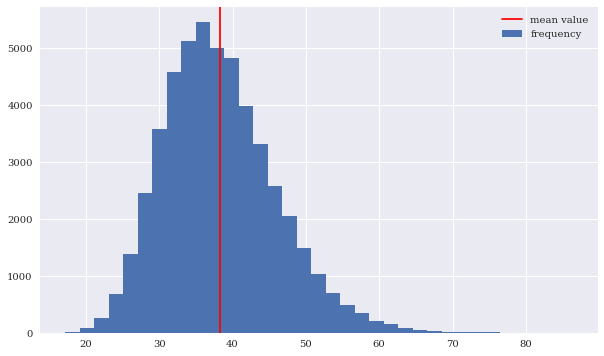

In [156]:
plt.figure(figsize=(10, 6))
plt.hist(S[-1], bins=35, label='frequency')
plt.axvline(S[-1].mean(), color='r', label='mean value')
plt.legend(loc=0)
# plt.savefig('../../images/ch10/perf_02.png');

### NumPy

In [157]:
def mcs_simulation_np(p):
    M, I = p
    dt = T / M
    S = np.zeros((M + 1, I))
    S[0] = S0
    rn = np.random.standard_normal(S.shape)
    for t in range(1, M + 1):  
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt +
                               sigma * math.sqrt(dt) * rn[t]) 
    return S      

In [158]:
%time S = mcs_simulation_np((M, I))

Wall time: 189 ms


In [159]:
S[-1].mean()

38.18713820376923

In [160]:
%timeit S = mcs_simulation_np((M, I))

190 ms ± 3.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Numba 

In [161]:
mcs_simulation_nb = numba.jit(mcs_simulation_py)

In [162]:
%time S = mcs_simulation_nb((M, I))  

Wall time: 597 ms


In [163]:
%time S = mcs_simulation_nb((M, I))  

Wall time: 173 ms


In [164]:
S[-1].mean()

38.18501549090336

In [165]:
C0 = math.exp(-r * T) * np.maximum(K - S[-1], 0).mean()

In [166]:
C0

3.873835314764223

In [167]:
%timeit S = mcs_simulation_nb((M, I))  

167 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Cython &mdash; Sequential

In [168]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp, sqrt
cdef float S0 = 36.
cdef float T = 1.0
cdef float r = 0.06
cdef float sigma = 0.2
@cython.boundscheck(False)
@cython.wraparound(False)
def mcs_simulation_cy(p):
    cdef int M, I
    M, I = p
    cdef int t, i
    cdef float dt = T / M
    cdef double[:, :] S = np.zeros((M + 1, I))
    cdef double[:, :] rn = np.random.standard_normal((M + 1, I))
    S[0] = S0
    for t in range(1, M + 1):
        for i in range(I):
            S[t, i] = S[t-1, i] * exp((r - sigma ** 2 / 2) * dt + sigma * sqrt(dt) * rn[t, i])
    return np.array(S) 

In [169]:
%time S = mcs_simulation_cy((M, I))

Wall time: 221 ms


In [170]:
S[-1].mean()

38.24637818367198

In [171]:
%timeit S = mcs_simulation_cy((M, I))

203 ms ± 5.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Multiprocessing

蒙特卡洛模拟是很适合并行化的任务。例如，方法之一是将10万条路径的模拟分为10个并行的进程，每个进程模拟1万条路径。另一种方法是将10万条路径的模拟分在多个进程中，每个进程模拟不同的金融工具。前者按照固定数量进程来并行模拟大量路径。

它将全部模拟路径（I）分为较小的块（p>0）。所有单独任务完成后，结果通过np.hstack()集中到一个ndarray对象。这种方法可应用于前面介绍的任何一个版本

In [144]:
import multiprocessing as mp

In [145]:
pool = mp.Pool(processes=4)  

In [146]:
p = 20  

In [147]:
%timeit S = np.hstack(pool.map(mcs_simulation_np, p * [(M, int(I / p))]))

148 ms ± 7.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [148]:
%timeit S = np.hstack(pool.map(mcs_simulation_nb, p * [(M, int(I / p))]))

138 ms ± 6.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [149]:
%timeit S = np.hstack(pool.map(mcs_simulation_cy, p * [(M, int(I / p))]))

146 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


多进程策略在金融业务中，有许多算法适用于并行化。其中一些算法甚至可以应用不同的代码并行化策略。蒙特卡洛模拟就是一个很好的例子，不管在单一机器或者多台机器上，都很容易并行执行多次模拟。这种算法本身还可以将单一模拟分布到多个进程上。

## Recursive pandas Algorithm

本节介绍一个在金融分析中很重要的特殊主题：在pandas的DataFrame对象中存储的金融时间序列上实现递归函数。虽然pandas可以在DataFrame对象上实现复杂的向量化操作，但某些递归算法很难或者无法向量化，金融分析人员不得不在DataFrame对象上执行缓慢的Python循环。

### Data and Formula

In [172]:
import numba
import numpy as np
import pandas as pd

In [173]:
sym = 'SPY'

In [174]:
data = pd.DataFrame(pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv', index_col=0, parse_dates=True)[sym]).dropna()

In [175]:
data

,SPY
Date,
2010-01-04,113.33
2010-01-05,113.63
2010-01-06,113.71
2010-01-07,114.19
2010-01-08,114.57
...,...
2018-06-25,271.00
2018-06-26,271.60
2018-06-27,269.35


In [176]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     2138 non-null   float64
dtypes: float64(1)
memory usage: 113.4 KB


In [177]:
alpha = 0.25

In [178]:
data['EWMA'] = data[sym]  

In [179]:
%%time
for t in zip(data.index, data.index[1:]):
    data.loc[t[1], 'EWMA'] = (alpha * data.loc[t[1], sym] + (1 - alpha) * data.loc[t[0],'EWMA'])  

Wall time: 443 ms


In [180]:
data.head()

,SPY,EWMA
Date,,
2010-01-04,113.33,113.330000
2010-01-05,113.63,113.405000
2010-01-06,113.71,113.481250
2010-01-07,114.19,113.658438
2010-01-08,114.57,113.886328


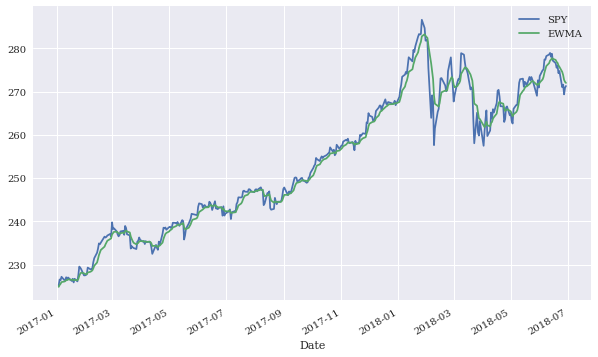

In [181]:
data[data.index > '2017-1-1'].plot(figsize=(10, 6));
# plt.savefig('../../images/ch10/perf_03.png');

### Pure Python

In [182]:
def ewma_py(x, alpha):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1-alpha) * y[i-1]
    return y

In [183]:
%time data['EWMA_PY'] = ewma_py(data[sym], alpha)  

Wall time: 7.99 ms


In [185]:
%time data['EWMA_PY'] = ewma_py(data[sym].values, alpha)  

Wall time: 1.99 ms


### Numba

In [186]:
ewma_nb = numba.jit(ewma_py)

In [187]:
%time data['EWMA_NB'] = ewma_nb(data[sym].values, alpha)  

Wall time: 117 ms


In [188]:
%timeit data['EWMA_NB'] = ewma_nb(data[sym].values, alpha)  

92.2 µs ± 290 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Cython

In [189]:
%%cython
import numpy as np
cimport cython
@cython.boundscheck(False)
@cython.wraparound(False)
def ewma_cy(double[:] x, float alpha):
    cdef int i
    cdef double[:] y = np.empty_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i - 1]
    return y

In [190]:
%time data['EWMA_CY'] = ewma_cy(data[sym].values, alpha)

Wall time: 2 ms


In [191]:
%timeit data['EWMA_CY'] = ewma_cy(data[sym].values, alpha)

520 µs ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [192]:
data.head()

,SPY,EWMA,EWMA_PY,EWMA_NB,EWMA_CY
Date,,,,,
2010-01-04,113.33,113.330000,113.330000,113.330000,113.330000
2010-01-05,113.63,113.405000,113.405000,113.405000,113.405000
2010-01-06,113.71,113.481250,113.481250,113.481250,113.481250
2010-01-07,114.19,113.658438,113.658438,113.658438,113.658438
2010-01-08,114.57,113.886328,113.886328,113.886328,113.886328


In [168]:
data.tail()

,SPY,EWMA,EWMA_PY,EWMA_NB,EWMA_CY
Date,,,,,
2018-06-25,271.00,274.535176,274.535176,274.535176,274.535176
2018-06-26,271.60,273.801382,273.801382,273.801382,273.801382
2018-06-27,269.35,272.688537,272.688537,272.688537,272.688537
2018-06-28,270.89,272.238903,272.238903,272.238903,272.238903
2018-06-29,271.28,271.999177,271.999177,271.999177,271.999177


将算法翻译成Python编程语言通常很容易。但是，由于性能上有很多种选择，所以算法的实现形式也很容易造成执行缓慢。对于交互式金融分析来说，最优的解决方案（也就是可以达到目的，但可能不是最快、也不是内存效率最高的）可能就足够了。对于生产型金融引用，应该坚持实现最好的解决方案，即使需要一些研究和正式基准测试都在所不惜。